In [1]:
import psycopg2

import pandas as pd
import numpy as np

from copy import deepcopy

import ast

import networkx as nx

import itertools

import matplotlib.pyplot as plt

In [3]:
sehir_matches_by_guid = pd.read_csv('../datasets/sehir_matches.csv', index_col="GUID.1").drop("GUID", axis=1)
sehir_matches_by_guid["sehir_matches"] = sehir_matches_by_guid["sehir_matches"].apply(lambda x: ast.literal_eval(x)[0][0])
sehir_matches_by_guid.head(5)

,sehir_matches,twitter_screen_name,twitter_name,profile_description,followers_count,friends_count,favourites_count,statuses_count,lang,cleaned_twitter_name
GUID.1,,,,,,,,,,
1032253818,cem kurtulus,cemkurtulmus,CEMKURTULMUŞ,NaN,426,284,945,1727,tr,cemkurtulmus
1241505234,caner ozdemir,AMASYABELBASKAN,Cafer ÖZDEMİR,NaN,4338,333,65,3559,tr,cafer ozdemir
190493057,ebru gunes,EbruGundes,Ebru Gündeş,NaN,2019824,46,3,5214,tr,ebru gundes
145723363,sumeyye zengin,summeye,Sümeyye Zengin,NaN,116,358,288,634,tr,sumeyye zengin
2279504925,ahmet kaya,ahmet_kayaa44,Ahmet Kaya,NaN,450,1949,45,46,tr,ahmet kaya


In [4]:
df_by_twitter_name = sehir_matches_by_guid.set_index("cleaned_twitter_name")
df_by_twitter_name.head()

,sehir_matches,twitter_screen_name,twitter_name,profile_description,followers_count,friends_count,favourites_count,statuses_count,lang
cleaned_twitter_name,,,,,,,,,
cemkurtulmus,cem kurtulus,cemkurtulmus,CEMKURTULMUŞ,NaN,426,284,945,1727,tr
cafer ozdemir,caner ozdemir,AMASYABELBASKAN,Cafer ÖZDEMİR,NaN,4338,333,65,3559,tr
ebru gundes,ebru gunes,EbruGundes,Ebru Gündeş,NaN,2019824,46,3,5214,tr
sumeyye zengin,sumeyye zengin,summeye,Sümeyye Zengin,NaN,116,358,288,634,tr
ahmet kaya,ahmet kaya,ahmet_kayaa44,Ahmet Kaya,NaN,450,1949,45,46,tr


In [5]:
len(df_by_twitter_name)

2276

In [6]:
# for twitter_name in df_by_twitter_name.index:
#     G.add_node(twitter_name)

In [7]:
# for std in sehir_matches_by_guid.index:
#     G.add_node(std)

## Connect to sql Database

In [8]:
connection = psycopg2.connect('dbname=twitter_accounts_new host=localhost user=postgres password=1_sehir_1')

twitter_users = pd.read_sql("SELECT * FROM twitter_user", connection)\
.rename(columns={'id': 'GUID', 
                 'name': 'twitter_name',
                 'description': 'profile_description',
                 'screen_name': 'twitter_screen_name'})

user_connections = pd.read_sql("SELECT * FROM twitter_connection", connection).drop('id', axis=1)

In [9]:
G = nx.DiGraph()
users_ids = dict()  # user name > id
ids_users = dict()  # user id > name

In [10]:
for i, row in user_connections.iterrows():
    from_ = row['from_user_id']
    to = row['to_user_id']
    try:
        from_name = sehir_matches_by_guid.loc[from_]["sehir_matches"]
        to_name = sehir_matches_by_guid.loc[to]["sehir_matches"]
    except (KeyError,TypeError) as e:
        continue
#         print(from_name, to_name)
    if "sehir" in from_name or "sehir" in to_name:
        continue
    if type(from_name) == str:
        from_name = [from_name]
    if type(to_name) == str:
        to_name = [to_name]
    from_to = itertools.product(list(from_name), list(to_name))
    for f,t in from_to:
        users_ids.setdefault(f, len(users_ids))
        ids_users[users_ids[f]] = (from_, f)
        
        users_ids.setdefault(t, len(users_ids))
        ids_users[users_ids[t]] = (to, t)
        
        G.add_edge(users_ids[f],users_ids[t])

In [11]:
len(users_ids)

1470

In [12]:
G.number_of_nodes()

1470

In [13]:
G.number_of_edges()

2806

## Augmenting the nodes with information

In [14]:
for ix in list(G.nodes()):
    twitter_id, sehir_name = ids_users[ix]
    match = sehir_matches_by_guid.loc[twitter_id]
    if type(match) == pd.DataFrame: # handling duplicate rows for the same twitter ids
        # handling duplicate rows for the same twitter ids and sehir name (different fb ids)
        if type(match.set_index("sehir_matches").loc[sehir_name]) == pd.DataFrame:
            match = list(match.iterrows())[0][1]  # just picking the first ones
    for k, v in match.items():
        try:
            G.node[ix][k] = int(v)  # making sure it is not np.int64 to appeal to JSON
        except ValueError:
            G.node[ix][k] = str(v)
    G.node[ix].pop("profile_description")

## Adding Network metrics

In [15]:
for ix,deg in G.degree(G.nodes()):
    G.node[ix]['degree'] = deg
    G.node[ix]['parity'] = (1-deg%2)
    
for ix,in_deg in G.in_degree(G.nodes()):
    G.node[ix]['in_degree'] = in_deg
    
for ix,out_deg in G.out_degree(G.nodes()):
    G.node[ix]['out_degree'] = out_deg

In [16]:
evc = nx.eigenvector_centrality(G)
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)

In [17]:
# com_cen = nx.communicability_betweenness_centrality(G)

In [18]:
metrics = {"eigenvector_centrality":evc,
           "closeness_centrality":closeness,
          "betweenness":betweenness}

In [19]:
for metric_name, metric in metrics.items():
    for ix,v in metric.items():
        G.node[ix][metric_name] = v

In [20]:
list(G.nodes(data=True))[0]

(0,
 {'betweenness': 0.0013614703880190607,
  'cleaned_twitter_name': 'elif ozturk',
  'closeness_centrality': 0.29539513372209936,
  'degree': 2,
  'eigenvector_centrality': 0.007231384968238733,
  'favourites_count': 1,
  'followers_count': 46,
  'friends_count': 146,
  'lang': 'en',
  'parity': 1,
  'sehir_matches': 'elif ozturk',
  'statuses_count': 2,
  'twitter_name': 'Elif Öztürk',
  'twitter_screen_name': 'bidikshowtime'})

## Dumping the graph to json file for D3 interactive visualization

In [21]:
import json
from networkx.readwrite import json_graph
data = nx.node_link_data(G)
with open('twitter_users_graph2.json', 'w') as f:
    json.dump(data, f, indent=4)

## Drawing the Network

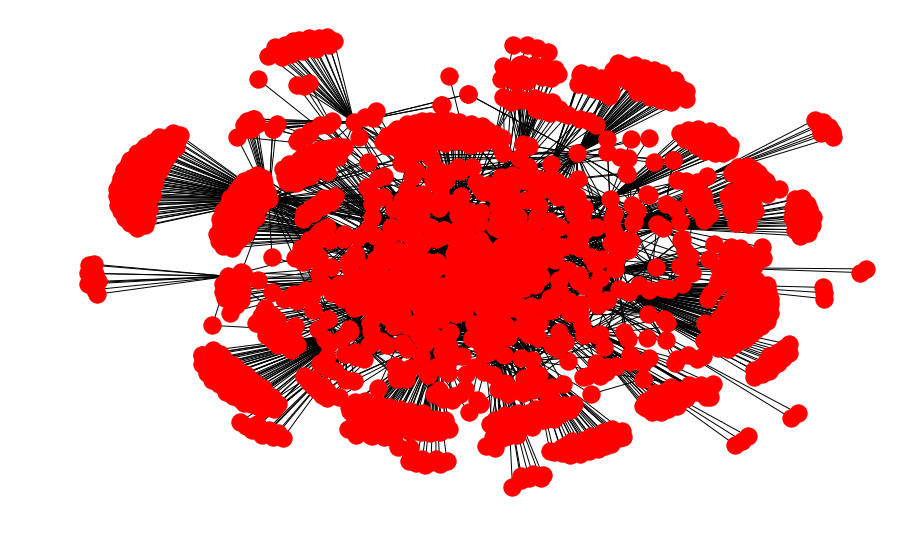

In [22]:
plt.figure(figsize=(12, 7))
# plt.figure(figsize=(200, 100))
graph_no_labels = nx.draw(G, pos=nx.spring_layout(G),with_labels=False)
plt.savefig('no_label_graph.pdf', format='pdf')

In [ ]:
plt.figure(figsize=(12, 7))
# plt.figure(figsize=(200, 100))
graph_with_labels = nx.draw(G, pos=nx.spring_layout(G),with_labels=True)
plt.savefig('graph.pdf', format='pdf')